# Variables with the same importance, testing intra-chain Variable Importance calculation  

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from scipy import stats

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Data generation

In [3]:
X = pd.DataFrame(
    np.random.uniform(low=0, high=1.0, size=(100, 5)), columns=list("01234")
)
f_x = np.sum(X, axis=1)
Y = rng.normal(f_x, 1)
range_x = list(range(X.shape[1]))  # ticks for the x-axis in the plots

## Different number of variables  

Using default options of BART and 4 chains.

In [4]:
VIs = []

with pm.Model() as model:
    μ = pmb.BART("μ", X, Y)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=Y)
    idata = pm.sample(chains=4, random_seed=RANDOM_SEED)
    # Mean Variable Importance
    VI = idata.sample_stats["variable_inclusion"].mean(("chain", "draw")).values
    VIs.append(VI / VI.sum())

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: xlabel='0'>, <Axes: xlabel='1'>, <Axes: xlabel='2'>,
       <Axes: xlabel='3'>, <Axes: xlabel='4'>], dtype=object)

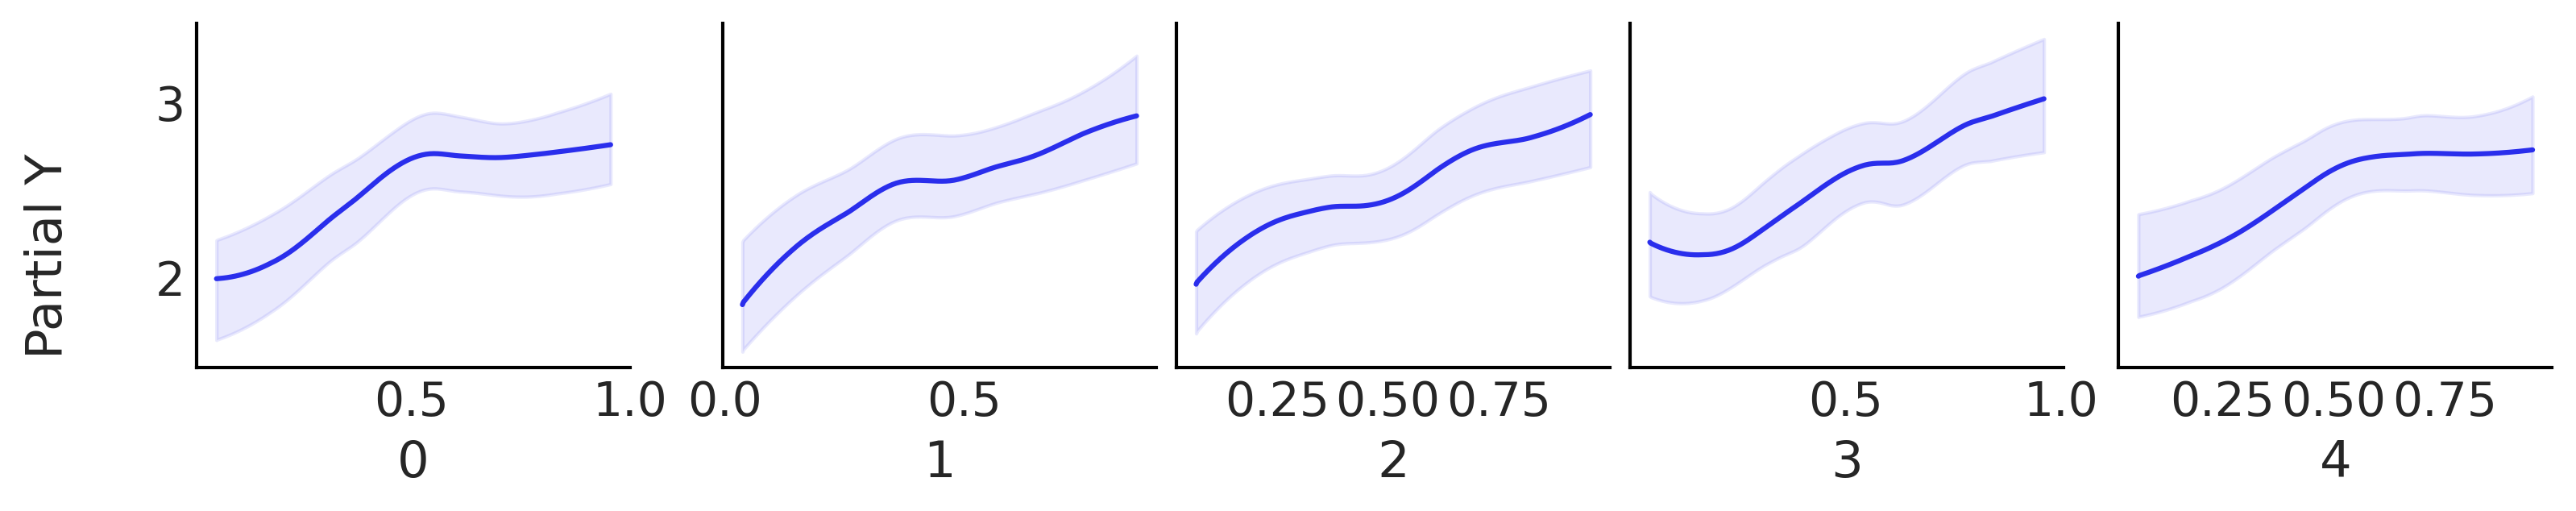

In [31]:
var_id = range(min(10, 5))
pmb.plot_pdp(μ, X, Y, var_idx=var_id, grid=(1, 5), figsize=(10, 2));

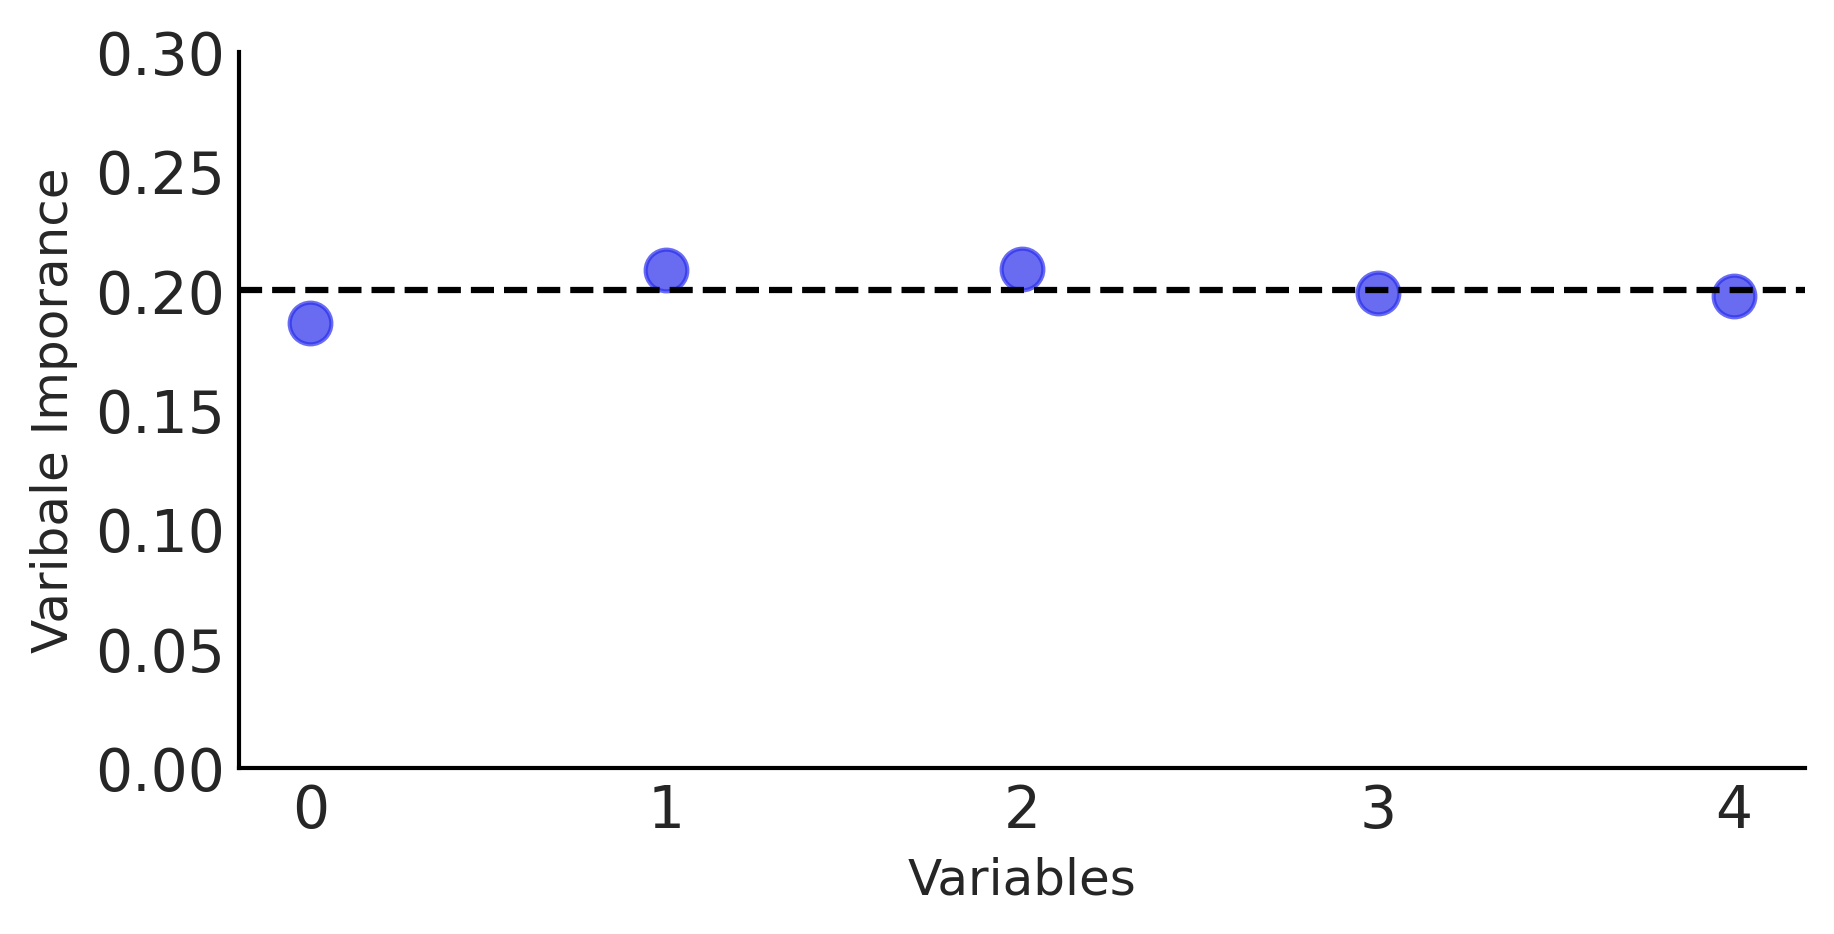

In [5]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(range_x, VIs, s=100, alpha=0.7)
ax.axhline(1 / X.shape[1], ls="--", color="k")
ax.set_xticks(range_x)
ax.set_xlabel("Variables", fontsize=12)
ax.set_ylabel("Varibale Imporance", fontsize=12)
plt.ylim(0, 0.3);

In [6]:
# Get the number of chains in the idata
chains = list(idata.sample_stats["variable_inclusion"]["chain"].values)

vis_chains = []
# Calculate VI mean for each chain
for chain in chains:
    vi_0 = idata.sample_stats["variable_inclusion"][chain].mean("draw")
    vis_chains.append(vi_0 / vi_0.sum())

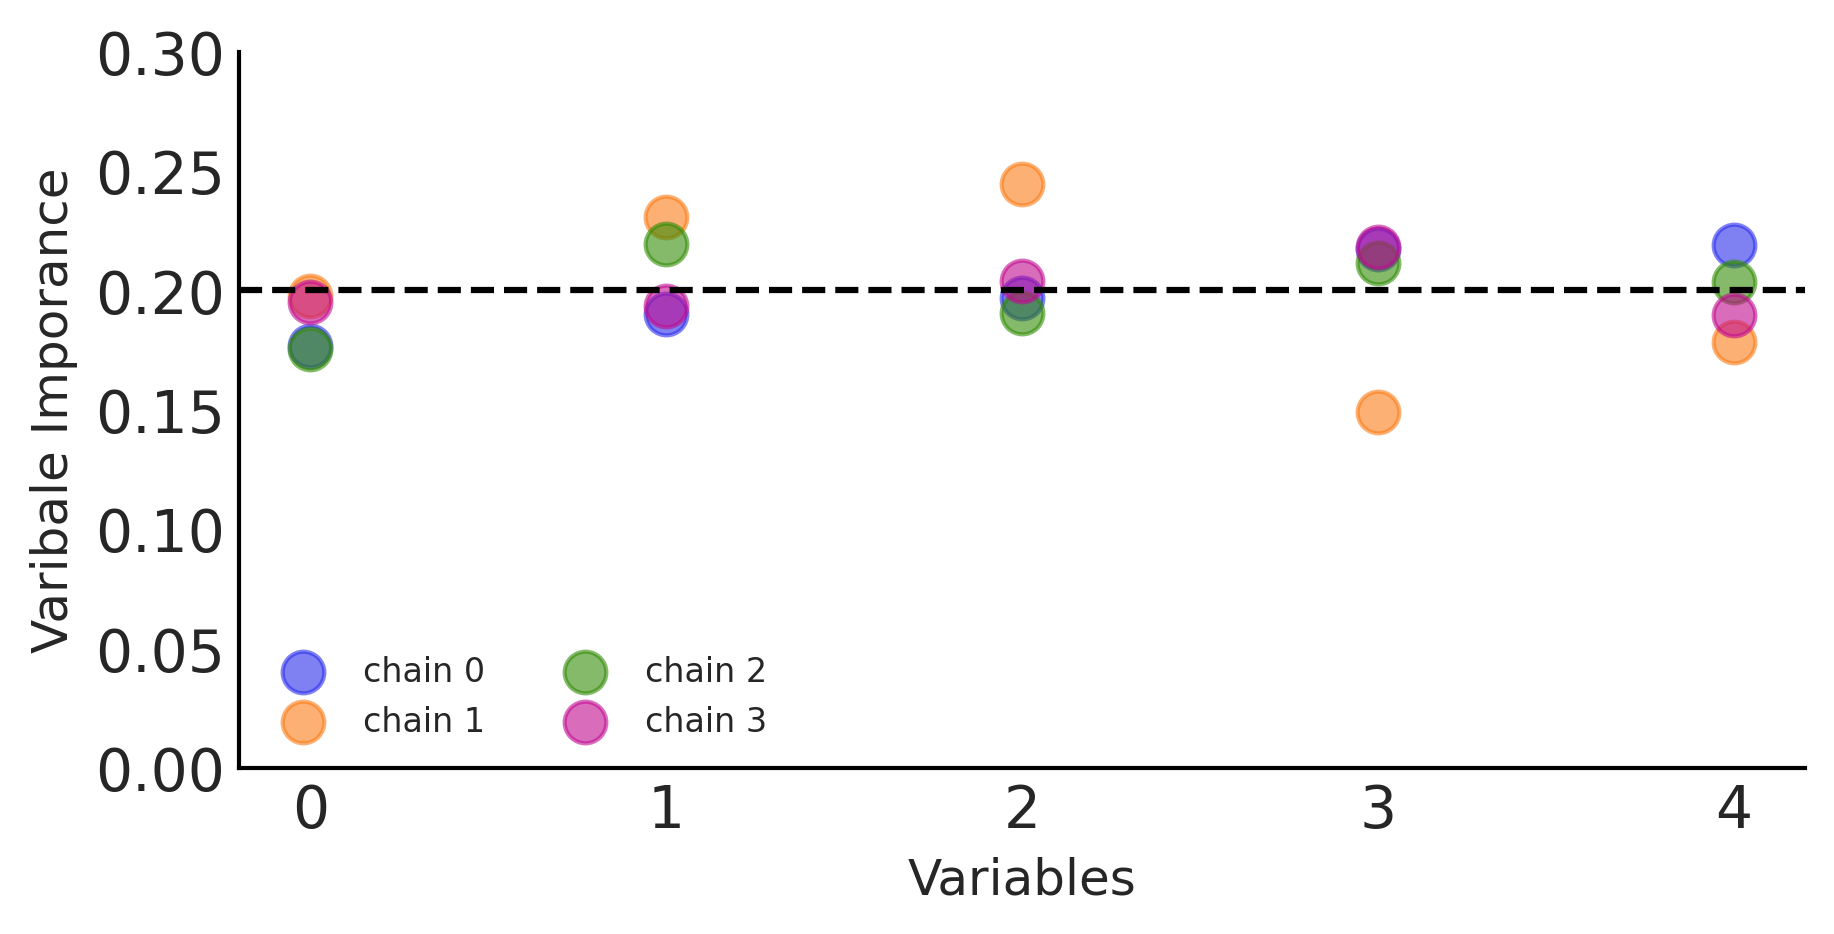

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))

for i in range(0, len(vis_chains)):
    ax.scatter(range_x, vis_chains[i], s=100, alpha=0.6, label=f"chain {i}")
plt.axhline(1 / X.shape[1], ls="--", color="k")

plt.legend(loc="lower left", ncol=2, fontsize=8)
ax.set_xticks(range_x)
ax.set_xlabel("Variables", fontsize=12)
ax.set_ylabel("Varibale Imporance", fontsize=12)
plt.ylim(0, 0.3)
plt.savefig("similar_VI_by_chain.png");

In [9]:
# Save the VI ordered by half of each chain
vis_half_chains = []
# Calculate the mean VI for each half-chain
for chain in chains:
    vi_0 = idata.sample_stats["variable_inclusion"][chain][0:499].mean("draw")
    vi_1 = idata.sample_stats["variable_inclusion"][chain][500:999].mean("draw")
    vis_half_chains.append(vi_0 / vi_0.sum())
    vis_half_chains.append(vi_1 / vi_1.sum())

names = ["1-a", "1-b", "2-a", "2-b", "3-a", "3-b", "4-a", "4-b"]

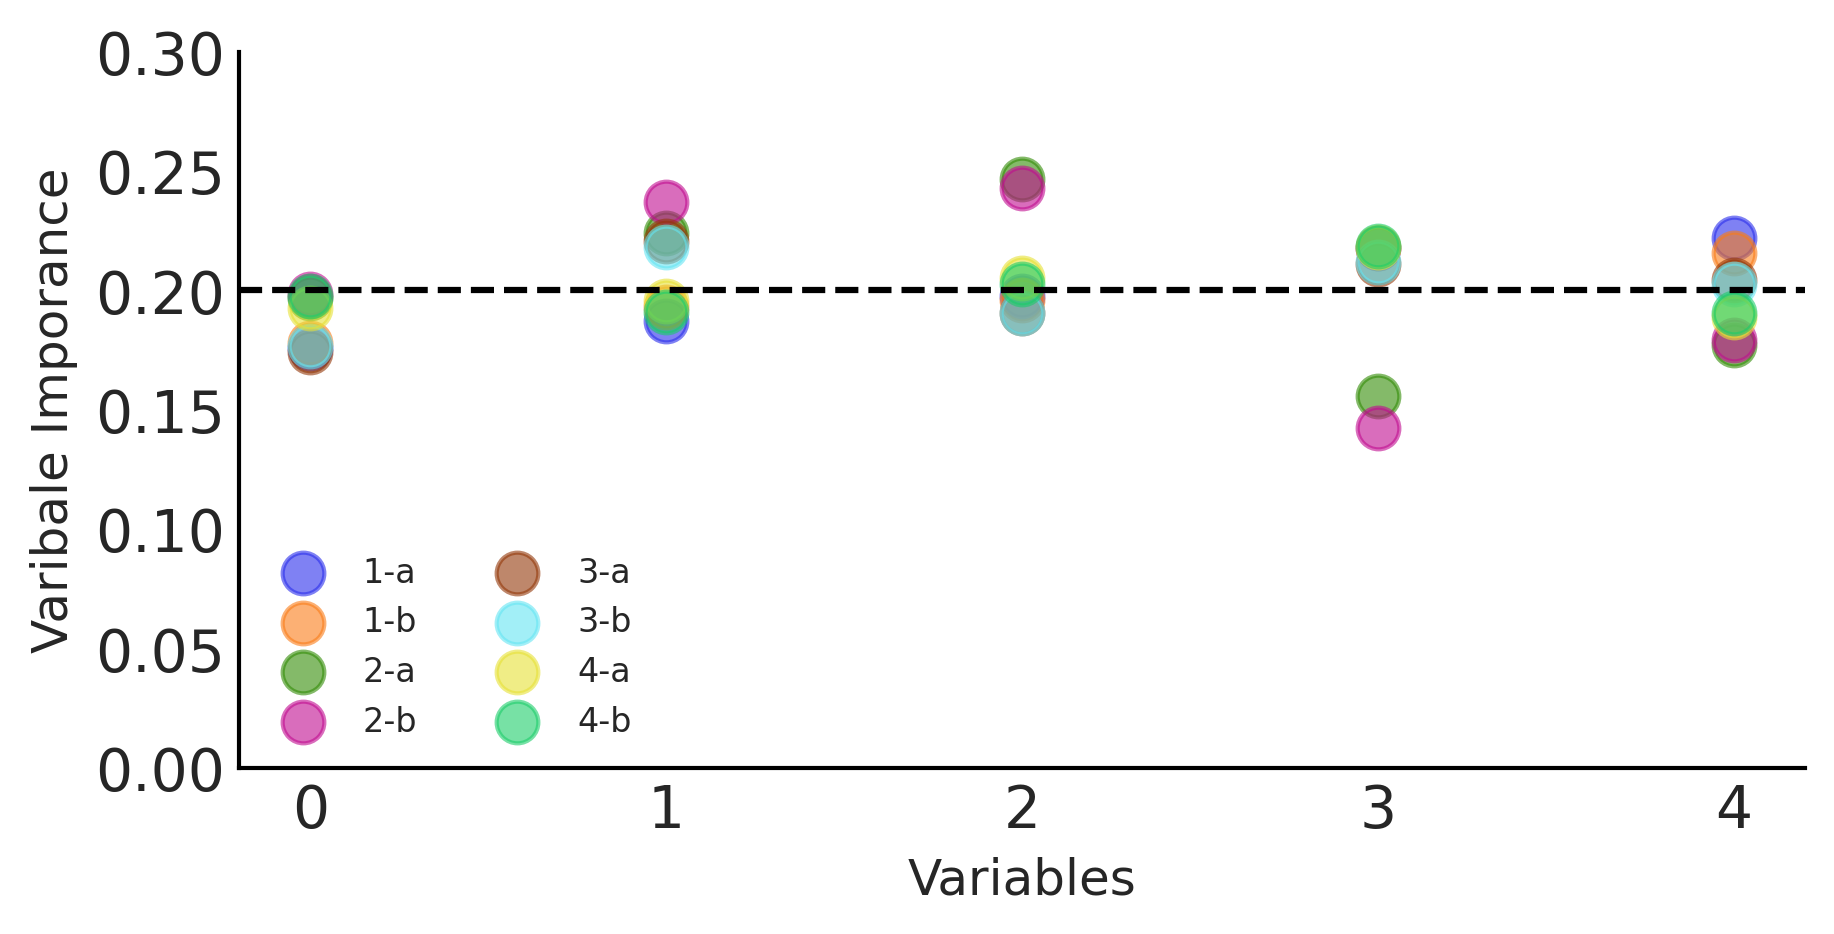

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))

for i in range(0, len(vis_half_chains)):
    ax.scatter(range_x, vis_half_chains[i], s=100, alpha=0.6, label=f"{names[i]}")
plt.axhline(1 / X.shape[1], ls="--", color="k")

plt.legend(loc="lower left", ncol=2, fontsize=8)
ax.set_xticks(range_x)
ax.set_xlabel("Variables", fontsize=12)
ax.set_ylabel("Varibale Imporance", fontsize=12)
plt.ylim(0, 0.3)
plt.savefig("similar_VI_half_chains.png")

In [14]:
n = len(chains) * 2  # amounts of covariables half chains
n_covar = X.shape[1]  # amounts of covariables
vis_arr = np.array(vis_half_chains)
vi_means = [vis_arr[:, i].mean() for i in range(0, n_covar)]
vi_stds = [vis_arr[:, i].std() for i in range(0, n_covar)]

In [28]:
hdi_prob = 0.68
hdi_ = stats.beta(n / 2, n / 2).ppf((1 - hdi_prob) / 2)
hdi_odds = np.array((hdi_ / (1 - hdi_), (1 - hdi_) / hdi_))
lim = hdi_odds / n_covar
Xs = np.array(range(X.shape[1]))

/home/pablo/anaconda3/envs/bart-variables/lib/python3.10/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


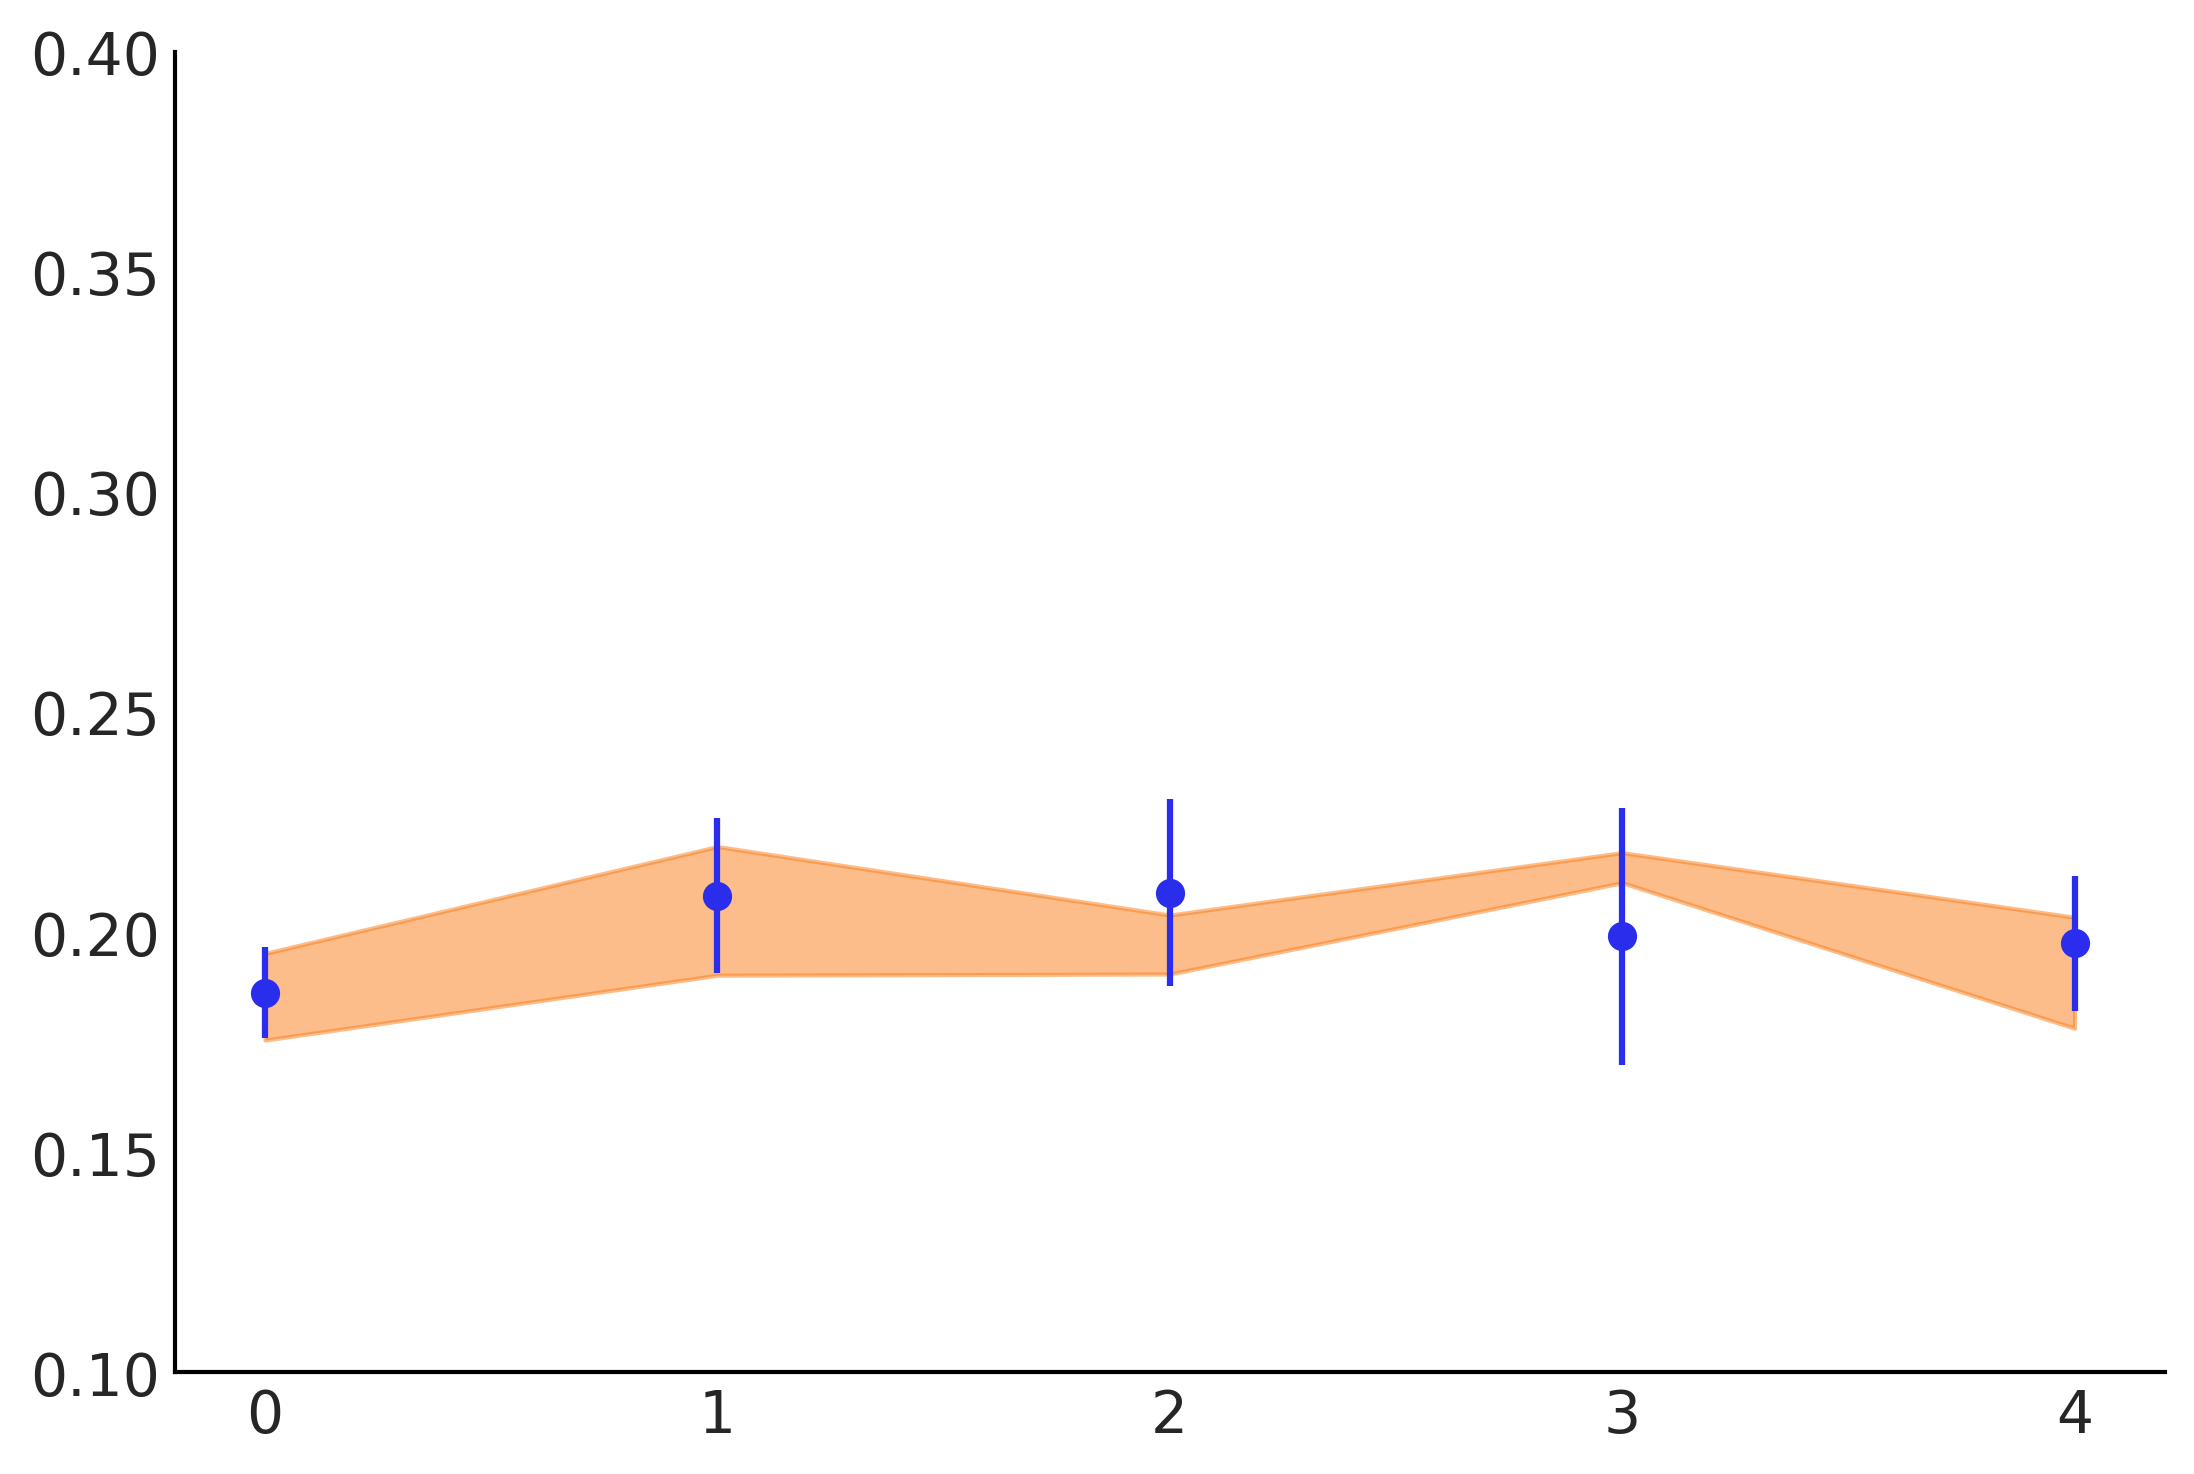

In [44]:
ax = az.plot_hdi(Xs, vis_chains, hdi_prob=hdi_prob, smooth=False)
ax.errorbar(x=Xs, y=vi_means, yerr=vi_stds, linestyle="None", marker="o", alpha=1)

ax.set_xticks(range_x)
ax.set_ylim(0.1, 0.4);

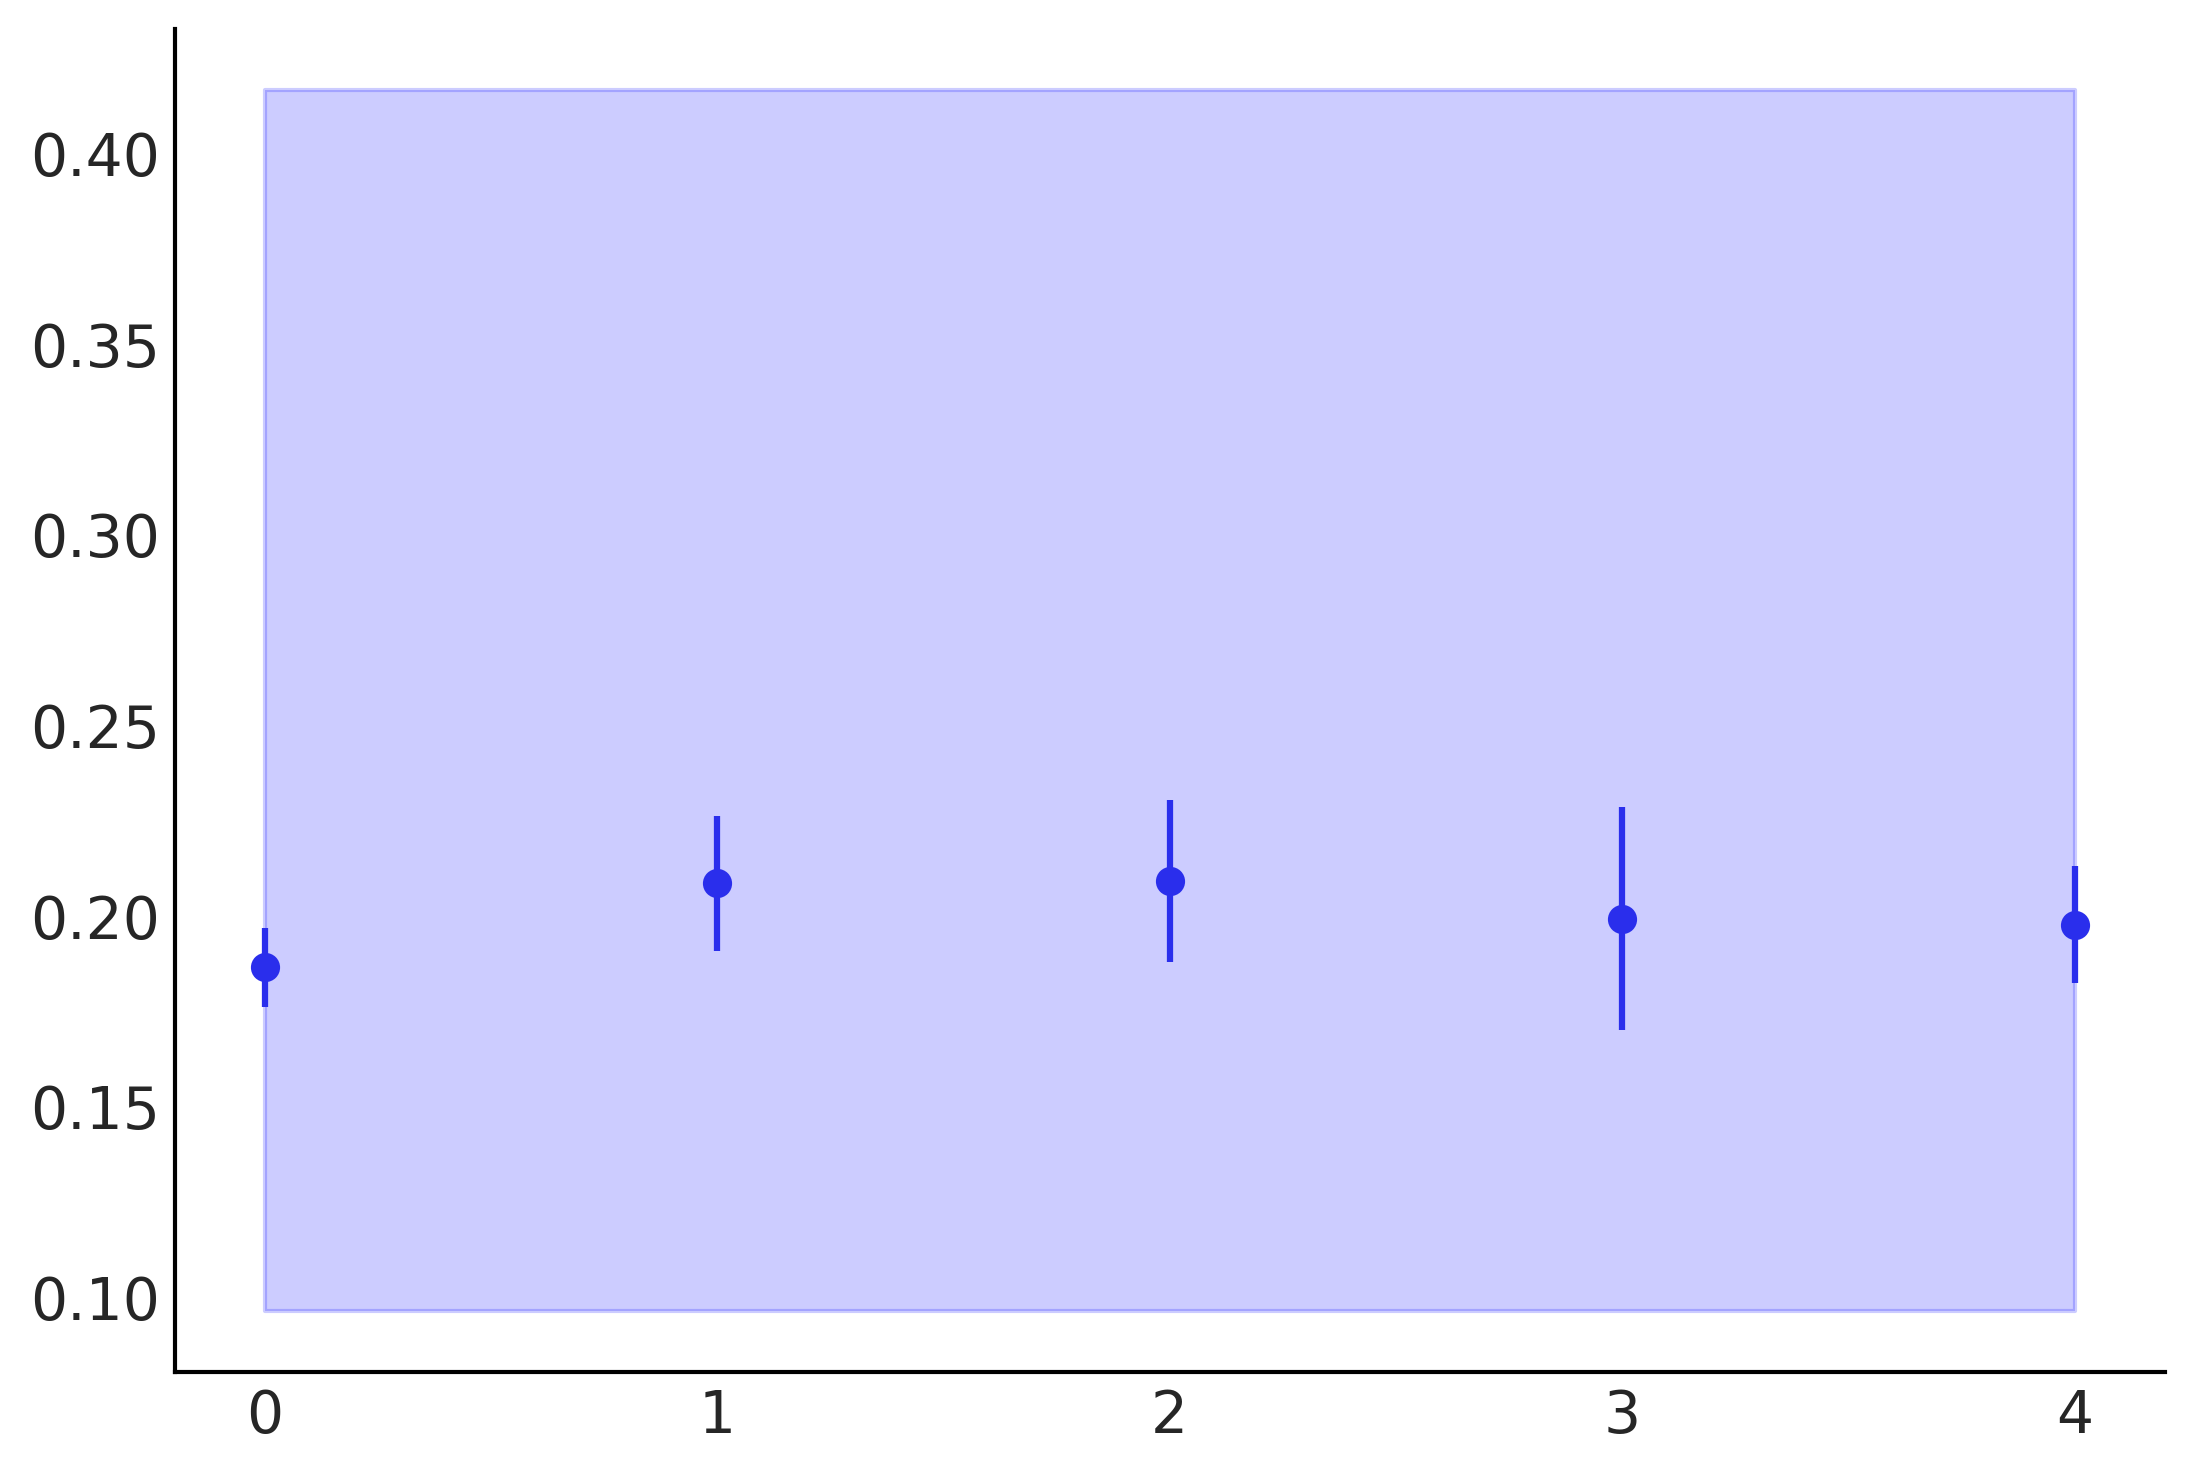

In [45]:
fig, ax = plt.subplots()
ax.fill_between(x=Xs, y1=lim[0], y2=lim[1], alpha=0.2, color="blue")
ax.errorbar(x=Xs, y=vi_means, yerr=vi_stds, linestyle="None", marker="o", alpha=1)

ax.set_xticks(range_x);